# Project Advanced Line Finding

The goals / steps of this project are the following:

### 1 Camera caiibration
*    Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

### 2 Create Pipeline
*    Apply a distortion correction to raw images.
*    Use color transforms, gradients, etc., to create a thresholded binary image.
*    Apply a perspective transform to rectify binary image ("birds-eye view").
*    Detect lane pixels and fit to find the lane boundary.
*    Determine the curvature of the lane and vehicle position with respect to center.
*    Save frame data and create averages
*    Sanity check the results and correct frames if needed
*    Merge the detected lane boundaries, curvature and center offset back onto the original image.

### 3 Video Processing    
*    Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
 


### Import libraries

In [6]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2 
import glob
%matplotlib inline
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# 1 Camera calibration

Computes the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [7]:
def camera_calibration(path):    
    # Collect calibration image names
    image_names = glob.glob(path)        
    # Arrays to store 3D object points and 2D image points
    object_points_list = []
    image_points_list = []
    
    # Calcutate object points. Z axis is always 0, because it is a flat object
    # x and y goes from 0 to 8 and from 0 to 5 
    object_points = np.zeros((6 * 9, 3), np.float32)
    object_points[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    
    # loop through the images
    for image_name in image_names:        
        image = mpimg.imread(image_name)
        
        # images loaded by mpimg.imread are RGB format. convert them to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # find the corners on the image
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        
        # if corners are found, append object_point_list with the object points 
        # calculated before. Also add the image points (corners)
        if ret == True:
            image_points_list.append(corners)
            object_points_list.append(object_points)
        else:
            print("Calibration failed: " + image_name)
    
    # print(str(len(object_points_list)) + " images processed successfuly")
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points_list, image_points_list, gray.shape[::-1], None, None)
    
    return mtx, dist

Calibration failed: camera_cal/calibration5.jpg
Calibration failed: camera_cal/calibration4.jpg
Calibration failed: camera_cal/calibration1.jpg


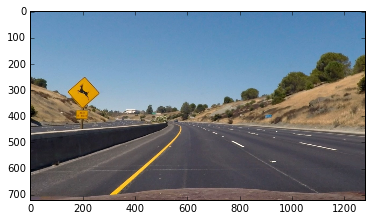

In [3]:
# Test camera calibration

image = mpimg.imread('test_images/test2.jpg')
plt.imshow(image)  
mtx, dist = camera_calibration('camera_cal/calibration*.jpg')
undist = cv2.undistort(image, mtx, dist)
# Show it

plt.imshow(undist)  
plt.savefig('output_images/calibrated_test2.jpg')


# 2 Create Pipeline

The pipeline creates the lane layer and computes curve radius. Takes the camera calibration results (calibration matrix and distortion parameteres)

In [20]:
def undistort_image(image, mtx, dist):
    result = cv2.undistort(image, mtx, dist)
    return result

In [19]:
# Filtering Saturation, hue in HSV color space and filtering x gradient was combined together
# Hue: around 30 is good for selecting yellow line
def create_warped_binary_image(image,sobel_x_thresh=(32,255), sobel_s_thresh=(235,250),sobel_h_thresh=(20,40)):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    h_channel = hsv[:,:,0]
    s_channel = hsv[:,:,1]
    v_channel = hsv[:,:,2]
    
    # Create x oriented gradient on value channel
    sobel_x_v = cv2.Sobel(v_channel, cv2.CV_64F, 1, 0)
    
    # take the absolut values
    sobel_x_v_abs = np.absolute(sobel_x_v)
    result = np.copy(image)
    
    # scale them to 8bit
    sobel_x_v_scaled = np.uint8(255 * sobel_x_v_abs / np.max(sobel_x_v_abs))
    sobel_x_v_binary = np.zeros_like(sobel_x_v_scaled)
    sobel_x_v_binary[(sobel_x_v_scaled >= sobel_x_thresh[0]) & (sobel_x_v_scaled < sobel_x_thresh[1])] = 1
    
    # Create gradient on saturation channel
    sobel_s_binary = np.zeros_like(s_channel)
    sobel_s_binary[(s_channel >= sobel_s_thresh[0]) & (s_channel < sobel_s_thresh[1])] = 1

    # Create gradient on hue channel
    sobel_h_binary = np.zeros_like(h_channel)
    sobel_h_binary[(h_channel >= sobel_h_thresh[0]) & (h_channel < sobel_h_thresh[1])] = 1
    
    # Create stacked image of previous binaries
    stacked = np.dstack((sobel_x_v_binary, sobel_s_binary,sobel_h_binary)) * 255
    return stacked

In [21]:
def perspective_transform(image):
    
    # result = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # source points are got manually with GIMP. Left and right margin are left on the bottom
    # to have some space to left and to right when the car isnt't at the exact center of the
    # lane
    #                          x1b,y1b,   x1t, y1t,   xrt, yrt,   yrb,yrb     
    # source =      np.float32([[100,719], [580, 450],[ 710, 455],[1200,719]])    
    source =      np.float32([[100,719], [553, 450],[ 737, 450],[1200,719]])    
    # Bottom destination points are equal to the sources. tops are streched out towards x and y
    destination = np.float32([[100,719], [100, 100],[1210, 100],[1200,719]])

    
    # Get the perscpective transform matrix
    M = cv2.getPerspectiveTransform(source, destination)
    Minv = cv2.getPerspectiveTransform(destination, source)
    Minv 
    cv2.warpPerspective(image, M,(1280,720), image)    
    return image, Minv

In [22]:
def find_lane_pixels(image):
    # convert to grayscale, color and gradient filters (R G B) should be equal 
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Try to detect lines on the bottom of the image. Lane curvature has no effect on
    # the bottom, The angle between lane and horizont is right angle, so stacking points
    # along y is good for detecting lanes
    histogram = np.sum(gray[gray.shape[0]//2:,:], axis=0)
    
    # convert back the result
    result = np.dstack((gray,gray,gray))
    
    # Middle X coordinate
    mid_x_point = np.int(histogram.shape[0]//2) 
            
    # Location of left lane on the bottom of image
    leftx_base = np.argmax(histogram[:mid_x_point])
    
    # Location of right lane on the bottom of image
    rightx_base = np.argmax(histogram[mid_x_point:]) + mid_x_point
        
    # Sliding window parameters 
    # number of windows along the y axis
    window_number = 7
    
    # +/- margin defines the width of each sliding window. 
    margin = 100 
    
    # Minimum pixels has to be found to recenter the window. Otherwise
    # some flaws could recenter it to an unwanted position
    minpix = 50
    
    # Calculate the height of sliding window
    window_height = np.int(gray.shape[0]//window_number)
    
    # Get the indices of non zero pixels
    nonzero = gray.nonzero()    
    nonzero_x = np.array(nonzero[1])
    nonzero_y = np.array(nonzero[0])
    
    # Current position of each sliding window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # These are the indices collected from each sliding window
    # a polynomial will be fitted to them later
    left_lane_indices = []
    right_lane_indices = []
    
    # Iterate over the sliding windows
    for window in range(window_number):
        # Define window coordinates
        win_y_low = gray.shape[0] - (window + 1) * window_height
        win_y_high = gray.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
                
        cv2.rectangle(result,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0),2)
        cv2.rectangle(result,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0),2)
        
        # Get the nonzero pixels in the sliding window
        left_lane_indices_curr_window = ((nonzero_x >= win_xleft_low) & (nonzero_x < win_xleft_high) & 
        (nonzero_y >= win_y_low) & (nonzero_y < win_y_high)).nonzero()[0]
        right_lane_indices_curr_window = ((nonzero_x >= win_xright_low) & (nonzero_x < win_xright_high) & 
        (nonzero_y >= win_y_low) & (nonzero_y < win_y_high)).nonzero()[0]    
        
        # Collect the lane pixels from the current sliding window 
        left_lane_indices = np.append(left_lane_indices,left_lane_indices_curr_window)
        right_lane_indices= np.append(right_lane_indices,right_lane_indices_curr_window)
            
        # Recenter the window to the average x position of selected pixels
        if len(left_lane_indices_curr_window) > minpix:
            leftx_current = np.int(np.mean(nonzero_x[left_lane_indices_curr_window]))
        if len(right_lane_indices_curr_window) > minpix:
            rightx_current = np.int(np.mean(nonzero_x[right_lane_indices_curr_window]))
        
        # Remove the unnecessary dimension from the arrays. Ignore errors
        try:
            left_lane_indices = np.concatenate(left_lane_indices)
            right_lane_indices = np.concatenate(right_lane_indices)
        except ValueError:
            pass
        
    # Get pixel positions of indice numbers
    leftx = nonzero_x[left_lane_indices.astype(int)]
    rightx = nonzero_x[right_lane_indices.astype(int)]
    
    lefty = nonzero_y[left_lane_indices.astype(int)]
    righty = nonzero_y[right_lane_indices.astype(int)]
    
    return leftx,lefty,rightx,righty,result

def polyfit_sliding_window(image,ym_per_pix,xm_per_pix):
    # Collect pixels of each lane
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(image)
    
    # Fit second order polynomials to each lane
    left_fit = np.polyfit(lefty, leftx,2)
    right_fit = np.polyfit(righty, rightx,2)

    # Fit polynomials in real dimensions for calculating curves
    left_fit_cr = np.polyfit(ym_per_pix*lefty, xm_per_pix*leftx,2)
    right_fit_cr = np.polyfit(ym_per_pix*righty, xm_per_pix*rightx,2)

    
    # Generate x and y values for plotting
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    try:
        left_fitx = left_fit[0]*(ploty**2) + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*(ploty**2) + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    return left_fitx, left_fit, left_fit_cr, right_fitx, right_fit, right_fit_cr, ploty

In [23]:
# Calculate curvature of left, right polynomial functions in meter
def calculate_curvature(left_fit_cr, right_fit_cr, ploty, ym_per_pix, xm_per_pix):
    y_eval = np.max(ploty)
    left_curvature = ((1+(2 * ym_per_pix * left_fit_cr[0]*y_eval+left_fit_cr[1])**2)**1.5)/ np.absolute(2*left_fit_cr[0])
    right_curvature = ((1+(2 * ym_per_pix * right_fit_cr[0]*y_eval+right_fit_cr[1])**2)**1.5)/ np.absolute(2*right_fit_cr[0])        
    return left_curvature, right_curvature

In [24]:
def merge_images(original, left_fitx, right_fitx, ploty, Minv, curvature, center_cmeters):
    result = np.copy(original)
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(result, np.int_([pts]), (0,255, 0))

    # Distort lanes back to the original image using invert matrix
    result = cv2.warpPerspective(result, Minv, (original.shape[1], original.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original, 1, result, 0.3, 0)
    font = cv2.FONT_HERSHEY_PLAIN
    
    cv2.putText(result, "Curvature: " + str(curvature) + " m", (230,50), font, 3, (20,255,20),2,cv2.LINE_AA)
    cv2.putText(result, "Offset from the center: " + str(center_cmeters) + " cm", (230,100), font, 3, (20,255,20),2,cv2.LINE_AA)
    
    return result  

In [25]:
class Line():
    def __init__(self):        
        # was the line detected in the last iteration?
        self.detected = False  
        # last frame where both lines detected
        self.last_good = None
        #All of the x values of recent polynomial
        self.fitx = None  
        # Average x values of the the recent polyline
        self.meanx = None
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        #self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #mean of radius of curvature
        self.mean_curvature = None         
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 


In [26]:
def sanity_check(left_fitx, right_fitx):
    global frame_counter
    global frames

    curr_frame_left = frames[2 * frame_counter]
    curr_frame_right = frames[2 * frame_counter + 1]

    error_found = False
    error_left = np.absolute(curr_frame_left.mean - curr_frame_left.bestx)
    error_right = np.absolute(curr_frame_right.mean - curr_frame_right.bestx)
        
    if error_left > 100:
        error_found = True        
        # fallback to previous frame
        # todo fallback to previous good frame
        curr_frame_left.detected = False
        if frame_counter > 0:
            last_good_frame = frames[2 * (frame_counter-1)].last_good
            left_fitx = frames[2 * last_good_frame].fitx
            
    if error_right > 100:
        error_found = True        
        curr_frame_right.detected = False
        curr_frame_left.detected = False
        if frame_counter > 0:
            last_good_frame = frames[2 * (frame_counter-1) + 1].last_good
            right_fitx = frames[2 * last_good_frame + 1].fitx
            
    # If error found then keep the last good frame number from the previous frame        
    if error_found:
        curr_frame_left.last_good = frames[2 * (frame_counter-1)].last_good
        curr_frame_right.last_good = frames[2 * (frame_counter-1)+1].last_good
    else:
        # If there were no error then update the good frame to the current frame 
        curr_frame_right.last_good = frame_counter
        curr_frame_left.last_good = frame_counter        
    
    return left_fitx, right_fitx

In [27]:
# Iteration parameter
n = 5

def save_line(left_fitx, left_fit, right_fitx, right_fit,left_curvature, right_curvature, image):
    global frame_counter
    global frames
    left_line = Line()
    left_line.id = frame_counter
    left_line.self_detected = True
    left_line.fitx = left_fitx
    left_line.mean = np.int(np.mean(left_fitx))            
    left_line.current_fit = left_fit
    left_line.radius_of_curvature = left_curvature
    
    right_line = Line()
    right_line.self_detected = True
    right_line.fitx = right_fitx
    right_line.id = frame_counter    
    right_line.mean = np.int(np.mean(right_fitx))            
    right_line.current_fit = right_fit
    right_line.radius_of_curvature = right_curvature
    
    # get average of last n iterations
    start_frame = frame_counter - n
    if start_frame < 0:
        start_frame = 0
    
    # Calculate the average x position of the last n frames for each line
    # mean value of each frames are averaged
    # If frame array contains less than n frames before the current one,
    # then only the available frames used, for example
    # at frame 0 : no frames
    # at frame 1 : frame 0
    # at frame 2 : frame 0, frame 1
    # ...
    
    # Calculate the distance between the line and the center
    # The last x value of each frames are averaged on the last n frame
        
    left_mean_history = []
    right_mean_history = []
    
    left_base_array = []
    right_base_array = []
    curvature_array = []
    
    for frame_idx in range(start_frame, frame_counter):
        curr_frame_left = frames[2 * frame_idx]
        curr_frame_right = frames[2 * frame_idx + 1]
        left_mean_history = np.append(left_mean_history, curr_frame_left.mean)
        right_mean_history = np.append(right_mean_history, curr_frame_right.mean)
        left_base_array = np.append(left_base_array, curr_frame_left.fitx[-1])
        right_base_array = np.append(right_base_array, curr_frame_right.fitx[-1])
        curvature_array = np.append(curvature_array, curr_frame_left.radius_of_curvature, curr_frame_right.radius_of_curvature )
    
    if len(left_mean_history) == 0:
        left_line.bestx = left_line.mean
        right_line.bestx = right_line.mean
        left_line.mean_curveture = left_line.radius_of_curvature
        right_line.mean_curveture = right_line.radius_of_curvature
        center_cmeters = 0
        
    else:            
        left_line.bestx = np.int(np.mean(left_mean_history))            
        right_line.bestx = np.int(np.mean(right_mean_history))  
        
        # smoothing curvature
        left_line.mean_curveture = np.int(np.mean(curvature_array))
        right_line.mean_curveture = np.int(np.mean(curvature_array))
                
        left_base = np.int(np.mean(left_base_array))
        right_base = np.int(np.mean(right_base_array))        
        center_pixel = (right_base + left_base) / 2 - image.shape[1]//2
                        
        # calculate offset using the polynomial: The average width of the lane on the bottom of the 
        # image is the distance between the two polynomials at y=max(y), it is about 930 pixels
        # The width of the lane IRL is about 3.7meters:
        road_width_meters = 3.7
        road_width_pixels = 930
        center_cmeters = np.int(100 * center_pixel * road_width_meters / road_width_pixels)        
        # I know, it is redundant to store this in both lanes
        left_line.line_base_pos = center_cmeters
        right_line.line_base_pos = center_cmeters
                           
    frames = np.append(frames,(left_line, right_line))
    return left_line.mean_curveture, center_cmeters

In [28]:
# global variables used to keep track of frames

# Pipeline
# original variable is the image that is kept along the function
# Result is stored in image variable in all stages

def pipeline(original, mtx, dist):
    global frame_counter
    ym_per_pix = 30/720
    xm_per_pix = 3.7/700

    image = undistort_image(original, mtx, dist)
    image = create_warped_binary_image(image)
    image, Minv = perspective_transform(image)
    left_fitx, left_fit, left_fit_cr, right_fitx, right_fit, right_fit_cr, ploty = polyfit_sliding_window(image,ym_per_pix,xm_per_pix)    
    left_curvature, right_curvature = calculate_curvature(left_fit, right_fit, ploty, ym_per_pix, xm_per_pix)    
    mean_curvature, center_cmeters = save_line(left_fitx, left_fit, right_fitx, right_fit,left_curvature, right_curvature,image)
    left_fitx, right_fitx = sanity_check(left_fitx, right_fitx)
    image = merge_images(original, left_fitx, right_fitx, ploty, Minv, mean_curvature, center_cmeters)     
    frame_counter = frame_counter + 1
    
    return image

### Test Pipeline

Test starts with the 2nd stage of pipeline. Undistort has been already checked at the previous chapter

Calibration failed: camera_cal/calibration5.jpg
Calibration failed: camera_cal/calibration4.jpg
Calibration failed: camera_cal/calibration1.jpg
['test_images/test5.jpg', 'test_images/test3.jpg', 'test_images/test1.jpg', 'test_images/test2.jpg', 'test_images/straight_lines2.jpg', 'test_images/test6.jpg', 'test_images/straight_lines1.jpg', 'test_images/test4.jpg']


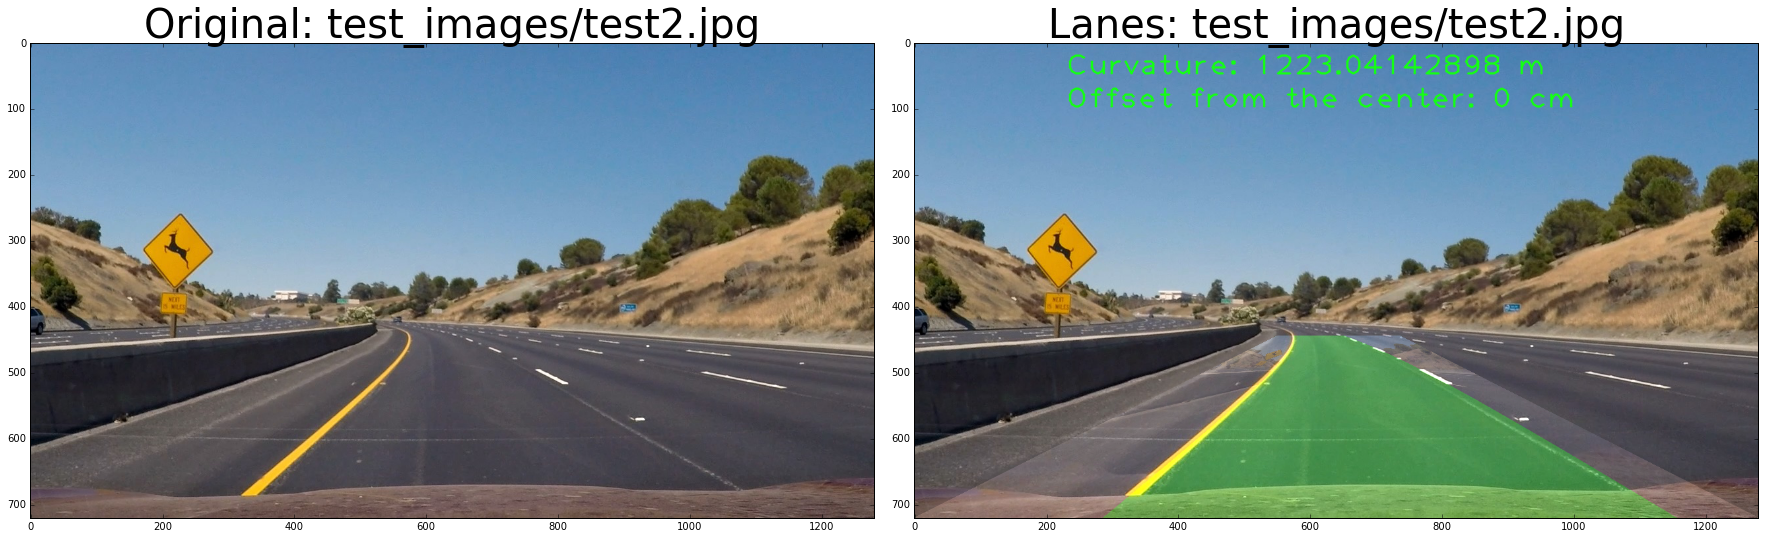

In [30]:
# Test pipeline on image 1

# Run camera calibration
mtx, dist = camera_calibration('camera_cal/calibration*.jpg')

image_names = glob.glob('test_images/*.jpg')   
frame_counter = 0
frames = []
print(image_names)
# for image_name in image_names:        
image_name='test_images/test2.jpg'
image = mpimg.imread(image_name)
# Run pipeline on the image
result  = pipeline(image, mtx, dist)
# create image space
f, (ax1,ax2) = plt.subplots(1,2, figsize=(24,9))
f.tight_layout()

ax1.imshow(image)  
ax1.set_title("Original: " + image_name, fontsize=40)
ax2.imshow(result)  
ax2.set_title("Lanes: " + image_name, fontsize=40)
plt.subplots_adjust(left=0.,right=1, top=0.9, bottom=0.)

plt.savefig('output_images/test2_merged.jpg')
    


# 3 Video processing

### Generate video output

In [ ]:
# ??? Redundant with Drawing 
def process_image(image):    
    return pipeline(image, mtx, dist)


In [ ]:
frames = []
frame_counter = 0


mtx, dist = camera_calibration('camera_cal/calibration*.jpg')

output_video = 'output.mp4'
#output_video = 'output_harder_challenge.mp4'
#output_video = 'output_error.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_video, audio=False)
